# 1. Базовый график
_Строим базовый график и производим обработку_

См. комментарии в разделе "параметры", остальное менять не требуется (кроме возможно формата обработки цветовой палитры, он ниже). Частота умножается на 2 поскольку в схеме двухпроходный АОМ.

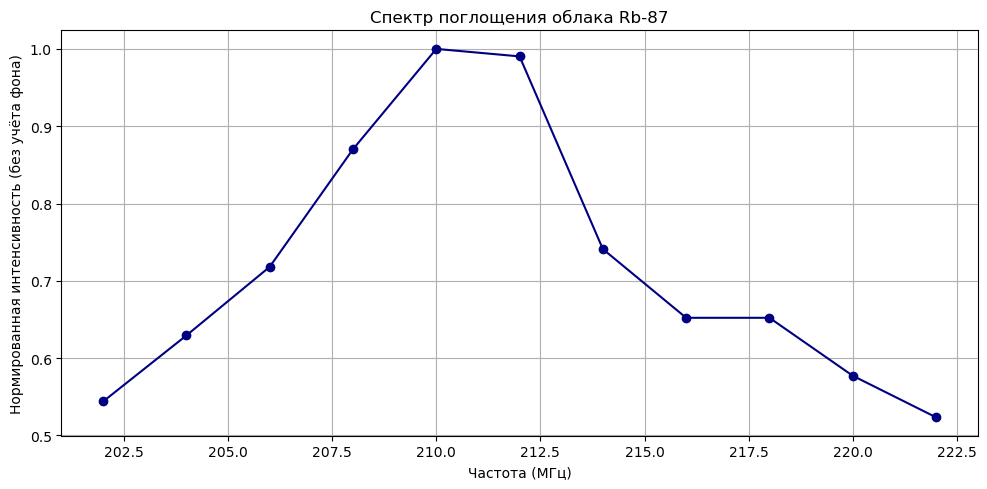

In [82]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Параметры
folder = "./Rubi87Spec/"  # путь к папке с .png-файлами, если лежат в текущей — оставить так
# frequencies = list(range(101*2, 112*2))  # 101–111 МГц * 2 т. к. АОМ двухпроходный
frequencies_raw = np.arange(101, 112)
frequencies = 2 * frequencies_raw  # [202, 204, ..., 222]

intensities = []

for f in frequencies_raw:
    filename = os.path.join(folder, f"{f}.png")
    img = Image.open(filename).convert("L") # ч/б
    cropped = img.crop(crop_box)
    arr = np.array(cropped, dtype=np.float32)
    intensities.append(arr.mean())
    crop_box = (737, 562, 781, 610)  # (left, upper, right, lower)

# Нормировка (опционально, в долях от максимума)
intensities = np.array(intensities)
norm_intensities = intensities / np.max(intensities)

# Построение графика
plt.figure(figsize=(10, 5))
plt.plot(frequencies, norm_intensities, 'o-', color='navy')
plt.xlabel("Частота (МГц)")
plt.ylabel("Нормированная интенсивность (без учёта фона)")
plt.title("Спектр поглощения облака Rb-87")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Наводим марафет
_Просто убираем соединение точек и добавляем аппроксимацию Гауссом_

Пик на 210.46 МГц, ширина (FWHM): 7.01 МГц


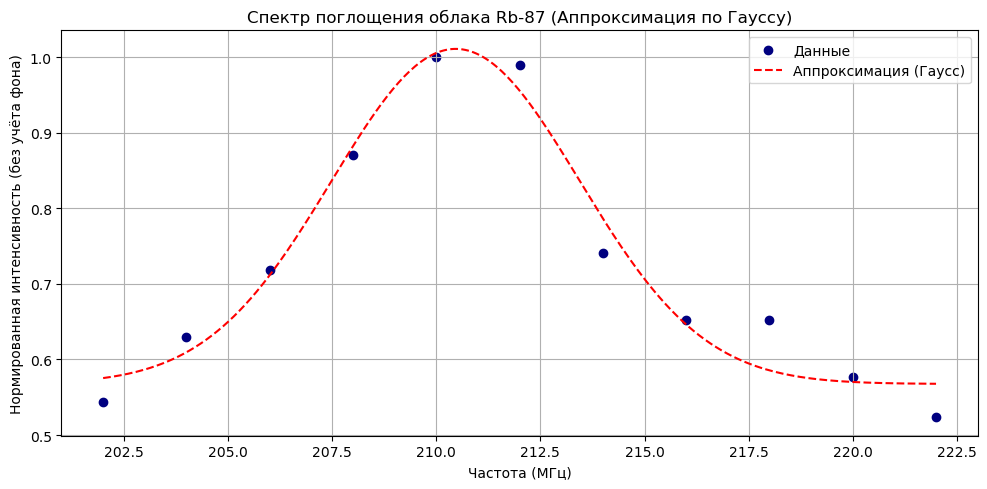

In [83]:
from scipy.optimize import curve_fit

def gauss(x, A, mu, sigma, C):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2)) + C

# Улучшенные начальные значения
A0 = np.max(norm_intensities) - np.min(norm_intensities)
mu0 = frequencies[np.argmax(norm_intensities)]
sigma0 = 1.0
C0 = np.min(norm_intensities)
p0 = [A0, mu0, sigma0, C0]

# Аппроксимация
popt, pcov = curve_fit(gauss, frequencies, norm_intensities, p0=p0)

# Параметры
A, mu, sigma, C = popt
fwhm = 2.355 * abs(sigma)

print(f"Пик на {mu:.2f} МГц, ширина (FWHM): {fwhm:.2f} МГц")

# Построение графика
plt.figure(figsize=(10, 5))
plt.scatter(frequencies, norm_intensities, color='navy', label="Данные")  # без соединения точек
x_fit = np.linspace(min(frequencies), max(frequencies), 300)
plt.plot(x_fit, gauss(x_fit, *popt), 'r--', label="Аппроксимация (Гаусс)")

plt.xlabel("Частота (МГц)")
plt.ylabel("Нормированная интенсивность (без учёта фона)")
plt.title("Спектр поглощения облака Rb-87 (Аппроксимация по Гауссу)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 3. График ещё чуть улучшен
_Добавлено обозначение пика с указанием значения, улучшена наглядность_

Пик на 210.46 МГц, ширина (FWHM): 7.01 МГц


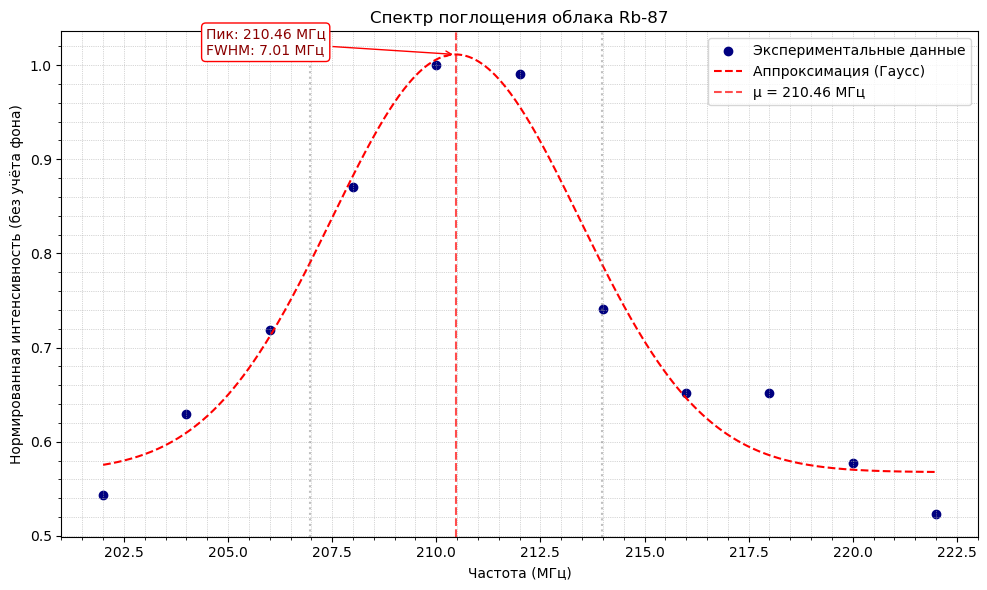

In [84]:
# Начальные значения
A0 = np.max(norm_intensities) - np.min(norm_intensities)
mu0 = frequencies[np.argmax(norm_intensities)]
sigma0 = 1.0
C0 = np.min(norm_intensities)
p0 = [A0, mu0, sigma0, C0]

# Аппроксимация
popt, pcov = curve_fit(gauss, frequencies, norm_intensities, p0=p0)
A, mu, sigma, C = popt
fwhm = 2.355 * abs(sigma)

print(f"Пик на {mu:.2f} МГц, ширина (FWHM): {fwhm:.2f} МГц")

# Построение графика
plt.figure(figsize=(10, 6))

# Сами данные
plt.scatter(frequencies, norm_intensities, color='navy', label="Экспериментальные данные")

# Аппроксимация
x_fit = np.linspace(min(frequencies), max(frequencies), 500)
y_fit = gauss(x_fit, *popt)
plt.plot(x_fit, y_fit, 'r--', label="Аппроксимация (Гаусс)")

# Вертикальные линии: пик и FWHM
plt.axvline(mu, color='red', linestyle='--', alpha=0.7, label=f"μ = {mu:.2f} МГц")
plt.axvline(mu - fwhm / 2, color='gray', linestyle=':', alpha=0.5)
plt.axvline(mu + fwhm / 2, color='gray', linestyle=':', alpha=0.5)

# Подпись над пиком
plt.annotate(f"Пик: {mu:.2f} МГц\nFWHM: {fwhm:.2f} МГц",
             xy=(mu, gauss(mu, *popt)), xytext=(mu - 6, gauss(mu, *popt) + 0.0001),
             arrowprops=dict(arrowstyle="->", color='red'),
             fontsize=10, color='darkred', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", lw=1))

# Оформление
plt.xlabel("Частота (МГц)")
plt.ylabel("Нормированная интенсивность (без учёта фона)")
plt.title("Спектр поглощения облака Rb-87")
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.minorticks_on()
plt.legend()
plt.tight_layout()
plt.show()

# 4. Добавлен расчет погрешностей некоторых параметров
_Погрешности параметров аппроксимации (в том числе μ и σ) были рассчитаны через стандартное средство curve_fit из библиотеки SciPy._

scipy.optimize.curve_fit() аппроксимирует заданную модель (в нашем случае — гауссову кривую) к экспериментальным данным методом наименьших квадратов, и возвращает:
	1.	popt — оптимальные параметры модели (A, μ, σ, C)
	2.	pcov — ковариационную матрицу этих параметров

Ковариационная матрица pcov выглядит примерно так:

$ \text{pcov} =
\begin{pmatrix}
\sigma_A^2 & \dots \\
\dots & \sigma_\mu^2 & \dots \\
\dots & \dots & \sigma_\sigma^2 & \dots \\
\dots & \dots & \dots & \sigma_C^2
\end{pmatrix} $

На диагонали — дисперсии оценённых параметров. Корни из них дают стандартные отклонения.

Мы выразили ширину пика через стандартное отклонение:

$ \text{FWHM} = 2.355 \cdot |\sigma| $

Тогда её погрешность (по правилу дифференцирования функций) будет:

$ \Delta\text{FWHM} = 2.355 \cdot \Delta\sigma $

Аналогично для частоты пика.

Пик на 210.46 ± 0.24 МГц
FWHM: 7.01 ± 0.75 МГц


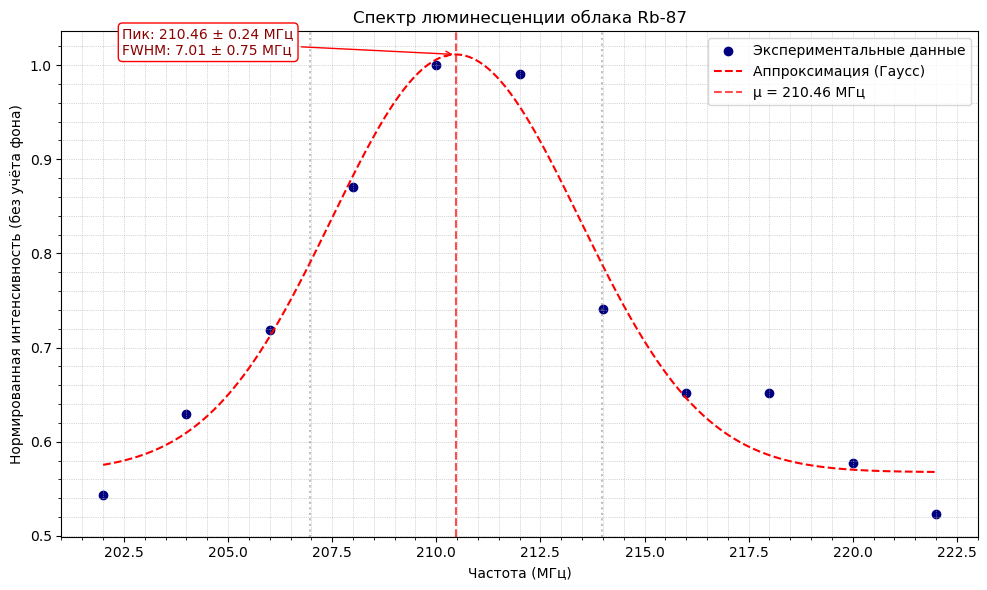

In [85]:
# Параметры и погрешности
popt, pcov = curve_fit(gauss, frequencies, norm_intensities, p0=p0)
A, mu, sigma, C = popt
perr = np.sqrt(np.diag(pcov))
mu_err = perr[1]
sigma_err = perr[2]
fwhm = 2.355 * abs(sigma)
fwhm_err = 2.355 * sigma_err

# Консольный вывод
print(f"Пик на {mu:.2f} ± {mu_err:.2f} МГц")
print(f"FWHM: {fwhm:.2f} ± {fwhm_err:.2f} МГц")

# Построение графика
plt.figure(figsize=(10, 6))

plt.scatter(frequencies, norm_intensities, color='navy', label="Экспериментальные данные")
x_fit = np.linspace(min(frequencies), max(frequencies), 500)
y_fit = gauss(x_fit, *popt)
plt.plot(x_fit, y_fit, 'r--', label="Аппроксимация (Гаусс)")

plt.axvline(mu, color='red', linestyle='--', alpha=0.7, label=f"μ = {mu:.2f} МГц")
plt.axvline(mu - fwhm / 2, color='gray', linestyle=':', alpha=0.5)
plt.axvline(mu + fwhm / 2, color='gray', linestyle=':', alpha=0.5)

# Подпись с погрешностями
plt.annotate(f"Пик: {mu:.2f} ± {mu_err:.2f} МГц\nFWHM: {fwhm:.2f} ± {fwhm_err:.2f} МГц",
             xy=(mu, gauss(mu, *popt)),
             xytext=(mu - 8, gauss(mu, *popt) + 0.0001),
             arrowprops=dict(arrowstyle="->", color='red'),
             fontsize=10, color='darkred',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", lw=1))

plt.xlabel("Частота (МГц)")
plt.ylabel("Нормированная интенсивность (без учёта фона)")
plt.title("Спектр люминесценции облака Rb-87")
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.minorticks_on()
plt.legend()
plt.tight_layout()
plt.show()

# 5. Замена аппроксимации Гауссом на аппроксимацию Лоренцевой функцией (как более ожидаемой)

Пик на 210.54 ± 0.19 МГц
FWHM: 8.85 ± 1.24 МГц


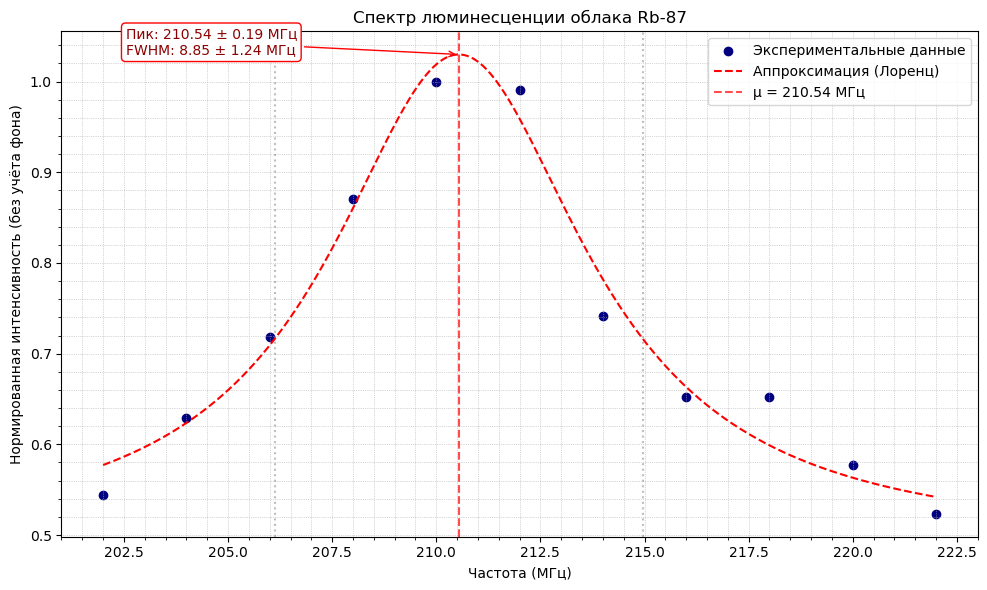

In [86]:
# Лоренцева функция
def lorentz(x, A, x0, gamma, C):
    return A / (1 + ((x - x0) / gamma) ** 2) + C

# Параметры и погрешности
popt, pcov = curve_fit(lorentz, frequencies, norm_intensities, p0=p0)
A, mu, sigma, C = popt
perr = np.sqrt(np.diag(pcov))
mu_err = perr[1]
sigma_err = perr[2]
fwhm = 2.355 * abs(sigma)
fwhm_err = 2.355 * sigma_err

# Консольный вывод
print(f"Пик на {mu:.2f} ± {mu_err:.2f} МГц")
print(f"FWHM: {fwhm:.2f} ± {fwhm_err:.2f} МГц")

# Построение графика
plt.figure(figsize=(10, 6))

plt.scatter(frequencies, norm_intensities, color='navy', label="Экспериментальные данные")
x_fit = np.linspace(min(frequencies), max(frequencies), 500)
y_fit = lorentz(x_fit, *popt)
plt.plot(x_fit, y_fit, 'r--', label="Аппроксимация (Лоренц)")

plt.axvline(mu, color='red', linestyle='--', alpha=0.7, label=f"μ = {mu:.2f} МГц")
plt.axvline(mu - fwhm / 2, color='gray', linestyle=':', alpha=0.5)
plt.axvline(mu + fwhm / 2, color='gray', linestyle=':', alpha=0.5)

# Подпись с погрешностями
plt.annotate(f"Пик: {mu:.2f} ± {mu_err:.2f} МГц\nFWHM: {fwhm:.2f} ± {fwhm_err:.2f} МГц",
             xy=(mu, lorentz(mu, *popt)),
             xytext=(mu - 8, lorentz(mu, *popt) + 0.0001),
             arrowprops=dict(arrowstyle="->", color='red'),
             fontsize=10, color='darkred',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", lw=1))

plt.xlabel("Частота (МГц)")
plt.ylabel("Нормированная интенсивность (без учёта фона)")
plt.title("Спектр люминесценции облака Rb-87")
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.minorticks_on()
plt.legend()
plt.tight_layout()
plt.show()

# 6. Относительное сравнение точности аппроксимирования различными функциями (Гаусс vs Лоренц)
_Здесь представлены два сравнительных значения:_

1.	R² (коэффициент детерминации) — показывает, насколько хорошо аппроксимация объясняет дисперсию данных. Чем ближе к 1 — тем лучше.

2.	RMSE (среднеквадратичная ошибка) — абсолютная метрика отклонения.

## Детальнее:
### 1. R² — коэффициент детерминации

R² (coefficient of determination) — это доля дисперсии, объяснённая моделью. То есть: насколько хорошо модель повторяет тренд данных.

Формула:
$ R^2 = 1 - \frac{SS_{\text{res}}}{SS_{\text{tot}}} $

Где:
$ SS_{\text{res}} = \sum (y_i - \hat{y}_i)^2 \text{ — сумма квадратов остатков (ошибок аппроксимации),} $
$ SS_{\text{tot}} = \sum (y_i - \bar{y})^2 \text{ — полная сумма квадратов, т.е. разброс относительно среднего значения } \bar{y}, $
$ y_i \text{ — экспериментальные данные,} $
$ \hat{y}_i \text{ — значения, предсказанные моделью.} $

Интерпретация:
	•	R² ≈ 1.00 — модель хорошо описывает данные.
	•	R² ≈ 0.00 — модель не объясняет дисперсию.
	•	R² < 0 — модель хуже, чем просто усреднение.

### 2. RMSE — среднеквадратичная ошибка

RMSE (Root Mean Squared Error) — это среднее отклонение предсказанных значений от реальных.

Формула:
$ \text{RMSE} = \sqrt{\frac{1}{n} \sum (y_i - \hat{y}_i)^2}, где: $
	•	n — количество точек,
	•	Остальные обозначения как выше.

Интерпретация:
	•	Измеряется в тех же единицах, что и данные (в данном случае — относительная интенсивность).
	•	Чем меньше RMSE, тем точнее модель (меньше отклонение от данных).

## Почему полезны вместе:
	•	R² показывает структурное соответствие модели данным.
	•	RMSE показывает фактическое среднее отклонение.

Иногда R² близок к 1, но RMSE остаётся большим — тогда есть систематическая ошибка.

[Гаусс] μ = 210.46 ± 0.24 МГц | FWHM = 7.01 ± 0.75 МГц | R² = 0.9597 | RMSE = 0.0321
[Лоренц] μ = 210.54 ± 0.19 МГц | FWHM = 7.52 ± 1.05 МГц | R² = 0.9722 | RMSE = 0.0267


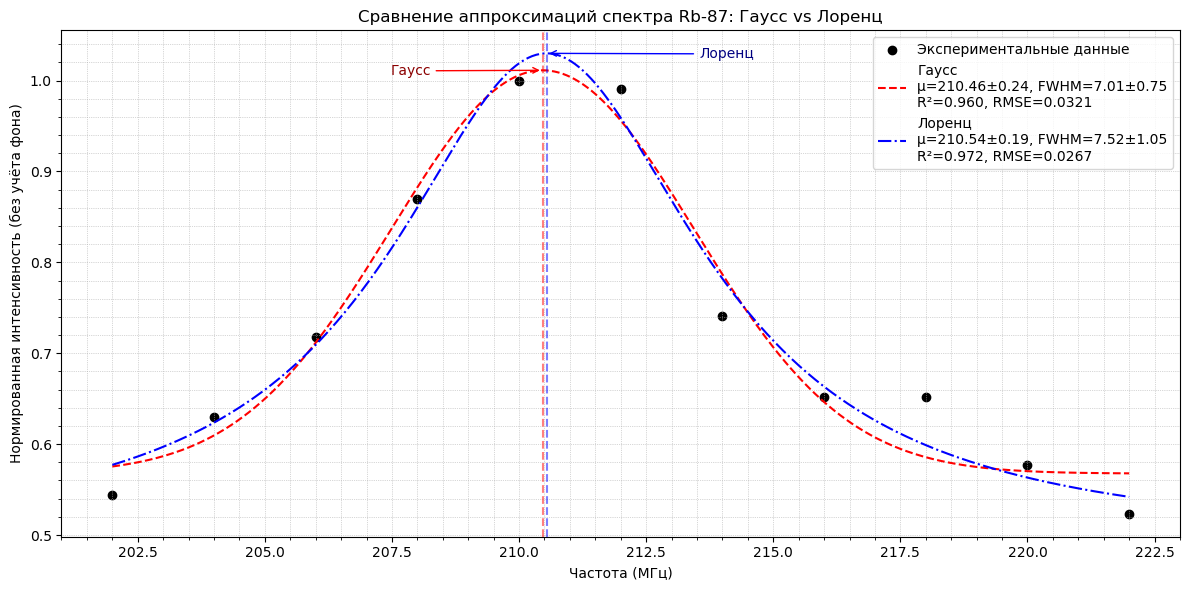

In [87]:
# Начальные параметры
A0 = np.max(norm_intensities) - np.min(norm_intensities)
mu0 = frequencies[np.argmax(norm_intensities)]
sigma0 = 1.0
C0 = np.min(norm_intensities)
p0_gauss = [A0, mu0, sigma0, C0]
p0_lorentz = [A0, mu0, sigma0, C0]

# Фит
popt_g, pcov_g = curve_fit(gauss, frequencies, norm_intensities, p0=p0_gauss)
Ag, mug, sigmag, Cg = popt_g
perr_g = np.sqrt(np.diag(pcov_g))
fwhm_g = 2.355 * abs(sigmag)
fwhm_err_g = 2.355 * perr_g[2]

popt_l, pcov_l = curve_fit(lorentz, frequencies, norm_intensities, p0=p0_lorentz)
Al, mul, gammal, Cl = popt_l
perr_l = np.sqrt(np.diag(pcov_l))
fwhm_l = 2 * abs(gammal)
fwhm_err_l = 2 * perr_l[2]

# Расчёт метрик
def metrics(y_true, y_pred):
    residuals = y_true - y_pred
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1 - ss_res / ss_tot
    rmse = np.sqrt(np.mean(residuals**2))
    return r2, rmse

y_gauss = gauss(np.array(frequencies), *popt_g)
y_lorentz = lorentz(np.array(frequencies), *popt_l)
r2_g, rmse_g = metrics(norm_intensities, y_gauss)
r2_l, rmse_l = metrics(norm_intensities, y_lorentz)

# Вывод
print(f"[Гаусс] μ = {mug:.2f} ± {perr_g[1]:.2f} МГц | FWHM = {fwhm_g:.2f} ± {fwhm_err_g:.2f} МГц | R² = {r2_g:.4f} | RMSE = {rmse_g:.4f}")
print(f"[Лоренц] μ = {mul:.2f} ± {perr_l[1]:.2f} МГц | FWHM = {fwhm_l:.2f} ± {fwhm_err_l:.2f} МГц | R² = {r2_l:.4f} | RMSE = {rmse_l:.4f}")

# Построение
plt.figure(figsize=(12, 6))
plt.scatter(frequencies, norm_intensities, color='black', label="Экспериментальные данные")

x_fit = np.linspace(min(frequencies), max(frequencies), 500)
plt.plot(x_fit, gauss(x_fit, *popt_g), 'r--',
         label=f"Гаусс\nμ={mug:.2f}±{perr_g[1]:.2f}, FWHM={fwhm_g:.2f}±{fwhm_err_g:.2f}\nR²={r2_g:.3f}, RMSE={rmse_g:.4f}")
plt.plot(x_fit, lorentz(x_fit, *popt_l), 'b-.',
         label=f"Лоренц\nμ={mul:.2f}±{perr_l[1]:.2f}, FWHM={fwhm_l:.2f}±{fwhm_err_l:.2f}\nR²={r2_l:.3f}, RMSE={rmse_l:.4f}")

plt.axvline(mug, color='red', linestyle='--', alpha=0.5)
plt.axvline(mul, color='blue', linestyle='--', alpha=0.5)

plt.annotate("Гаусс", xy=(mug, gauss(mug, *popt_g)),
             xytext=(mug - 3, gauss(mug, *popt_g) - 0.005),
             arrowprops=dict(arrowstyle="->", color='red'),
             fontsize=10, color='darkred')

plt.annotate("Лоренц", xy=(mul, lorentz(mul, *popt_l)),
             xytext=(mul + 3, lorentz(mul, *popt_l) - 0.005),
             arrowprops=dict(arrowstyle="->", color='blue'),
             fontsize=10, color='navy')

# Оформление
plt.title("Сравнение аппроксимаций спектра Rb-87: Гаусс vs Лоренц")
plt.xlabel("Частота (МГц)")
plt.ylabel("Нормированная интенсивность (без учёта фона)")
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.minorticks_on()
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

# 7. Добавлен свободный параметр фитирования (значение фоновой засветки C)
_Реализован перебор по C (константа соответствующая фоновой засветке) и сравнение аппроксимаций. Также реализована функция оценки C по яркости краёв изображений для сравнения с полученными в результате аппроксимации и произведена перенормировка._

[Гаусс] μ = 210.49 ± 0.27 МГц | FWHM = 8.30 ± 0.63 МГц | R² = 0.9450 | RMSE = 0.0375
[Гаусс] лучший C = 0.5234
[Лоренц] μ = 210.54 ± 0.18 МГц | FWHM = 7.46 ± 0.54 МГц | R² = 0.9722 | RMSE = 0.0267
[Лоренц] лучший C = 0.4914


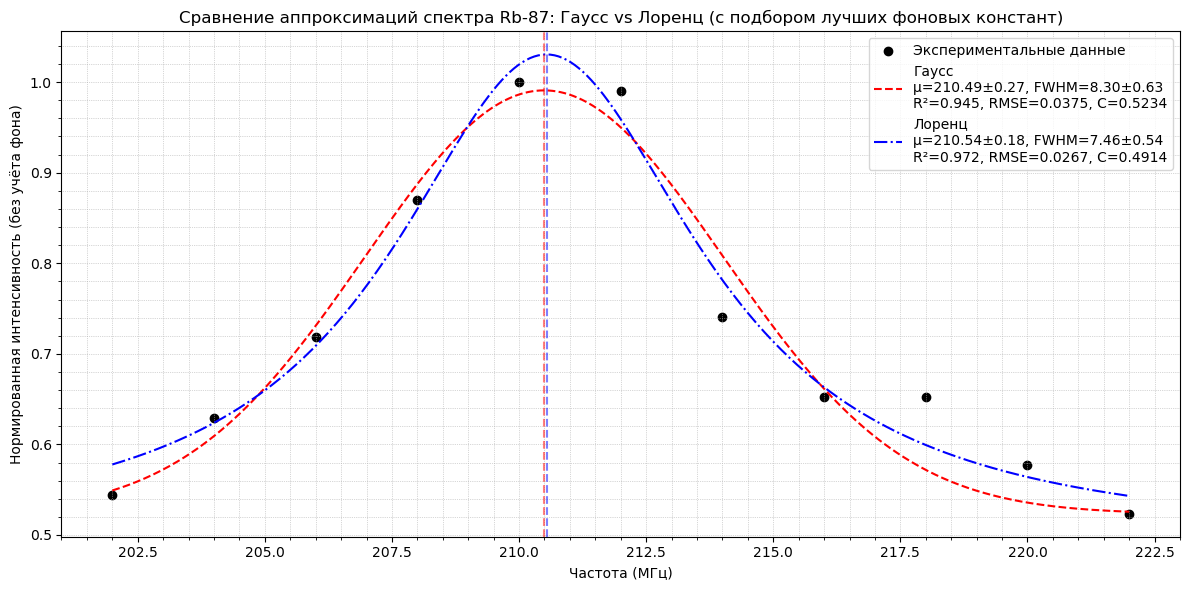

In [88]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Определение функций
def gauss(x, A, mu, sigma, C):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2)) + C

def lorentz(x, A, mu, gamma, C):
    return A * gamma**2 / ((x - mu)**2 + gamma**2) + C

def metrics(y_true, y_pred):
    residuals = y_true - y_pred
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1 - ss_res / ss_tot
    rmse = np.sqrt(np.mean(residuals**2))
    return r2, rmse

min_int = np.min(norm_intensities)
C_values = np.linspace(0, min_int, 50)

best_fit = {'gauss': None, 'lorentz': None}
best_rmse = {'gauss': np.inf, 'lorentz': np.inf}

# Начальные параметры без C
A0 = np.max(norm_intensities) - np.min(norm_intensities)
mu0 = frequencies[np.argmax(norm_intensities)]
sigma0 = 1.0

# Перебор по C
for C in C_values:
    try:
        # Гаусс
        p0_g = [A0, mu0, sigma0]
        popt_g, pcov_g = curve_fit(lambda x, A, mu, sigma: gauss(x, A, mu, sigma, C),
                                   frequencies, norm_intensities, p0=p0_g)
        y_pred_g = gauss(frequencies, *popt_g, C)
        _, rmse_g = metrics(norm_intensities, y_pred_g)
        if rmse_g < best_rmse['gauss']:
            best_rmse['gauss'] = rmse_g
            best_fit['gauss'] = (*popt_g, C)
            best_pcov_g = pcov_g

        # Лоренц
        p0_l = [A0, mu0, sigma0]
        popt_l, pcov_l = curve_fit(lambda x, A, mu, gamma: lorentz(x, A, mu, gamma, C),
                                   frequencies, norm_intensities, p0=p0_l)
        y_pred_l = lorentz(frequencies, *popt_l, C)
        _, rmse_l = metrics(norm_intensities, y_pred_l)
        if rmse_l < best_rmse['lorentz']:
            best_rmse['lorentz'] = rmse_l
            best_fit['lorentz'] = (*popt_l, C)
            best_pcov_l = pcov_l
    except:
        continue  # пропускаем неудачные попытки

# Извлечение лучших параметров
popt_g = best_fit['gauss']
popt_l = best_fit['lorentz']
pcov_g = best_pcov_g
pcov_l = best_pcov_l

perr_g = np.sqrt(np.diag(pcov_g))
perr_l = np.sqrt(np.diag(pcov_l))

Ag, mug, sigmag, Cg = popt_g
Al, mul, gammal, Cl = popt_l

fwhm_g = 2.355 * abs(sigmag)
fwhm_l = 2 * abs(gammal)
fwhm_err_g = 2.355 * perr_g[2]
fwhm_err_l = 2 * perr_l[2]

y_gauss = gauss(np.array(frequencies), *popt_g)
y_lorentz = lorentz(np.array(frequencies), *popt_l)
r2_g, rmse_g = metrics(norm_intensities, y_gauss)
r2_l, rmse_l = metrics(norm_intensities, y_lorentz)

# Вывод метрик
print(f"[Гаусс] μ = {mug:.2f} ± {perr_g[1]:.2f} МГц | FWHM = {fwhm_g:.2f} ± {fwhm_err_g:.2f} МГц | R² = {r2_g:.4f} | RMSE = {rmse_g:.4f}")
print(f"[Гаусс] лучший C = {Cg:.4f}")
print(f"[Лоренц] μ = {mul:.2f} ± {perr_l[1]:.2f} МГц | FWHM = {fwhm_l:.2f} ± {fwhm_err_l:.2f} МГц | R² = {r2_l:.4f} | RMSE = {rmse_l:.4f}")
print(f"[Лоренц] лучший C = {Cl:.4f}")

# Построение графика
plt.figure(figsize=(12, 6))
plt.scatter(frequencies, norm_intensities, color='black', label="Экспериментальные данные")
x_fit = np.linspace(min(frequencies), max(frequencies), 500)
plt.plot(x_fit, gauss(x_fit, *popt_g), 'r--',
         label=f"Гаусс\nμ={mug:.2f}±{perr_g[1]:.2f}, FWHM={fwhm_g:.2f}±{fwhm_err_g:.2f}\nR²={r2_g:.3f}, RMSE={rmse_g:.4f}, C={Cg:.4f}")
plt.plot(x_fit, lorentz(x_fit, *popt_l), 'b-.',
         label=f"Лоренц\nμ={mul:.2f}±{perr_l[1]:.2f}, FWHM={fwhm_l:.2f}±{fwhm_err_l:.2f}\nR²={r2_l:.3f}, RMSE={rmse_l:.4f}, C={Cl:.4f}")

plt.axvline(mug, color='red', linestyle='--', alpha=0.5)
plt.axvline(mul, color='blue', linestyle='--', alpha=0.5)

plt.title("Сравнение аппроксимаций спектра Rb-87: Гаусс vs Лоренц (с подбором лучших фоновых констант)")
plt.xlabel("Частота (МГц)")
plt.ylabel("Нормированная интенсивность (без учёта фона)")
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.minorticks_on()
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

In [89]:
def estimate_background_C(data, edge_fraction=0.1):
    """Оценивает фон (C) как среднее значение интенсивностей на краях спектра."""
    n = len(data)
    edge_len = int(n * edge_fraction)
    left_edge = data[:edge_len]
    right_edge = data[-edge_len:]
    edge_values = np.concatenate([left_edge, right_edge])
    return np.mean(edge_values)

C_estimate = estimate_background_C(norm_intensities)
print(f"Оценка фона засветки (C) по интенсивности (яркости) на краях обрезанных изображений (предположительно немного завышен \
— вероятно, до 10-15%), в выборке требуется фотография без захваченого и люминесцирующего облака для точного определения значения: \
{C_estimate:.4f}")

Оценка фона засветки (C) по интенсивности (яркости) на краях обрезанных изображений (предположительно немного завышен — вероятно, до 10-15%), в выборке требуется фотография без захваченого и люминесцирующего облака для точного определения значения: 0.5337


In [96]:
# --- Вычитание фона и перенормировка ---
"""На данном этапе просто возьмём среднее от трёх методов определения C"""
C_med = (Cg + Cl + C_estimate) / 3
corrected = np.clip(intensities - C_med, a_min=0, a_max=None)
norm_intensities = corrected / np.max(corrected)
print(f"C_med = {C_med}")
print(f"До коррекции: min={np.min(intensities):.3f}, max={np.max(intensities):.3f}")
print(f"После коррекции: min={np.min(corrected):.3f}, max={np.max(corrected):.3f}")

C_med = 0.5104554295539856
До коррекции: min=14.678, max=28.041
После коррекции: min=14.167, max=27.530


# 8. Финальная аппроксимация Лоренцом

Пик на 210.54 ± 0.19 МГц
FWHM: 8.85 ± 1.24 МГц


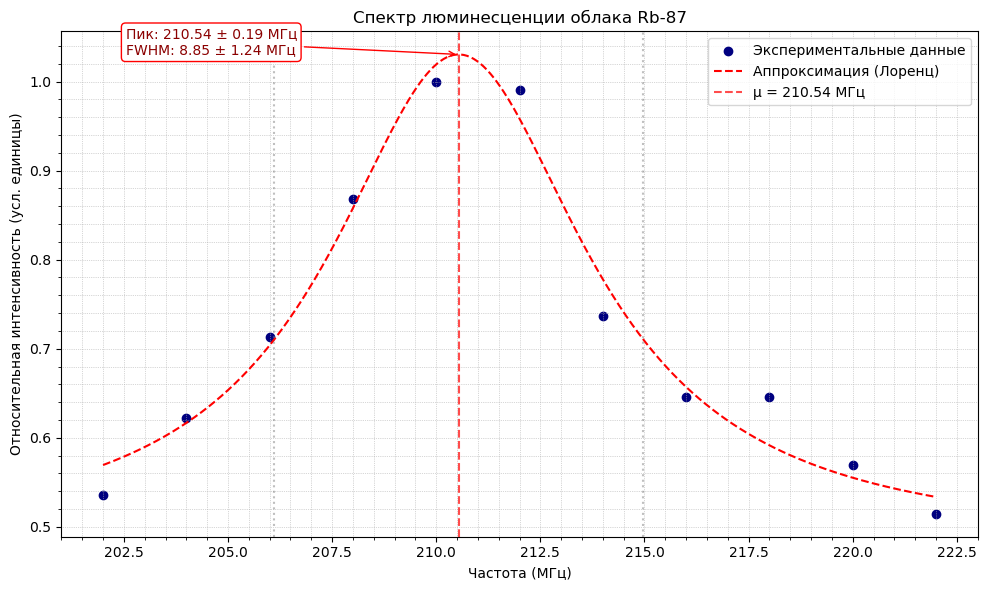

In [97]:
# Лоренцева функция
def lorentz(x, A, x0, gamma, C):
    return A / (1 + ((x - x0) / gamma) ** 2) + C

# Параметры и погрешности
popt, pcov = curve_fit(lorentz, frequencies, norm_intensities, p0=p0)
A, mu, sigma, C = popt
perr = np.sqrt(np.diag(pcov))
mu_err = perr[1]
sigma_err = perr[2]
fwhm = 2.355 * abs(sigma)
fwhm_err = 2.355 * sigma_err

# Консольный вывод
print(f"Пик на {mu:.2f} ± {mu_err:.2f} МГц")
print(f"FWHM: {fwhm:.2f} ± {fwhm_err:.2f} МГц")

# Построение графика
plt.figure(figsize=(10, 6))

plt.scatter(frequencies, norm_intensities, color='navy', label="Экспериментальные данные")
x_fit = np.linspace(min(frequencies), max(frequencies), 500)
y_fit = lorentz(x_fit, *popt)
plt.plot(x_fit, y_fit, 'r--', label="Аппроксимация (Лоренц)")

plt.axvline(mu, color='red', linestyle='--', alpha=0.7, label=f"μ = {mu:.2f} МГц")
plt.axvline(mu - fwhm / 2, color='gray', linestyle=':', alpha=0.5)
plt.axvline(mu + fwhm / 2, color='gray', linestyle=':', alpha=0.5)

# Подпись с погрешностями
plt.annotate(f"Пик: {mu:.2f} ± {mu_err:.2f} МГц\nFWHM: {fwhm:.2f} ± {fwhm_err:.2f} МГц",
             xy=(mu, lorentz(mu, *popt)),
             xytext=(mu - 8, lorentz(mu, *popt) + 0.0001),
             arrowprops=dict(arrowstyle="->", color='red'),
             fontsize=10, color='darkred',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", lw=1))

plt.xlabel("Частота (МГц)")
plt.ylabel("Относительная интенсивность (усл. единицы)")
plt.title("Спектр люминесценции облака Rb-87")
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.minorticks_on()
plt.legend()
plt.tight_layout()
plt.show()